# Detecção de Fraudes em Transações de Cartão de Crédito

Este notebook implementa um pipeline de Machine Learning de ponta a ponta para detectar transações fraudulentas de cartão de crédito.
Ele inclui:
1.  Carregamento de dados (reais ou geração de dados sintéticos).
2.  Engenharia de features para melhorar a capacidade preditiva do modelo.
3.  Técnicas para lidar com datasets desbalanceados (SMOTE).
4.  Divisão dos dados em conjuntos de treino e teste.
5.  Treinamento de um modelo `RandomForestClassifier`.
6.  Avaliação do modelo utilizando diversas métricas e análise da matriz de confusão.
7.  Visualização da importância das features.

## 1. Importações de Bibliotecas

Importamos todas as bibliotecas e módulos necessários para manipulação de dados, machine learning, e visualização.

In [26]:
# Manipulação de dados e matemática
import pandas as pd
import numpy as np
import os
import time

# Visualização (opcional, mas recomendado)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: geração de dados, divisão, modelo, métricas
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Imbalanced-learn: SMOTE para oversampling
# Certifique-se de ter instalado: pip install imbalanced-learn matplotlib seaborn
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
    print("Biblioteca 'imbalanced-learn' (para SMOTE) carregada com sucesso.")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("AVISO: Biblioteca 'imbalanced-learn' não encontrada. A funcionalidade SMOTE não estará disponível.")
    print("Para instalá-la, execute no seu terminal (com o venv ativo): pip install imbalanced-learn")

# Configurações de estilo para plots (opcional)
# %matplotlib inline # Se estiver usando ambiente Jupyter clássico ou quiser garantir plots inline
# plt.style.use('seaborn-v0_8-whitegrid') # Estilo de plot
# sns.set_style('whitegrid')

print("Bibliotecas e módulos básicos importados.")

Biblioteca 'imbalanced-learn' (para SMOTE) carregada com sucesso.
Bibliotecas e módulos básicos importados.


## 2. Configuração do Experimento

Defina os parâmetros para esta execução do pipeline. Você pode alterar esses valores para experimentar diferentes cenários.

In [12]:
# --- CONFIGURAÇÕES DO EXPERIMENTO ---

# Escolha da Fonte de Dados
USAR_DADOS_REAIS = True  # Mude para False para usar dados sintéticos

# Configurações para Dados Reais (se USAR_DADOS_REAIS = True)
# Certifique-se que este caminho está correto em relação à localização do seu notebook
CAMINHO_DADOS_REAIS = '../data/creditcard.csv'
COLUNA_ALVO_REAL = 'Class'

# Configurações para Dados Sintéticos (se USAR_DADOS_REAIS = False)
N_AMOSTRAS_SINTETICOS = 20000
N_FEATURES_SINTETICOS = 20 # Número de features antes da engenharia
PESOS_CLASSES_SINTETICOS = [0.99, 0.01] # Simula desbalanceamento (1% classe positiva)

# Configuração do SMOTE (aplicado ao conjunto de treino)
APLICAR_SMOTE_NO_TREINO = True # Mude para False para não aplicar SMOTE

# Parâmetros do Modelo RandomForestClassifier
# Estes são os parâmetros que você pode querer ajustar baseados nos seus testes com ui.py ou GridSearchCV
MODEL_PARAMS = {
    'n_estimators': 150,
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'random_state': 42,
    'verbose': 0,          # Mantenha 0 para menos output no notebook, 1 ou mais para progresso do RF
    'n_jobs': -1           # Usar todos os cores da CPU
}

# Limiar de Classificação para converter probabilidades em predições de classe
LIMIAR_CLASSIFICACAO = 0.5

# Semente aleatória para reprodutibilidade geral
RANDOM_STATE = 42

print("Configurações do experimento definidas.")
if USAR_DADOS_REAIS:
    print(f"  Modo: Dados Reais ('{CAMINHO_DADOS_REAIS}')")
else:
    print("  Modo: Dados Sintéticos")
print(f"  Aplicar SMOTE no treino: {'Sim' if APLICAR_SMOTE_NO_TREINO else 'Não'}")
print(f"  Parâmetros do Modelo: {MODEL_PARAMS}")
print(f"  Limiar de Classificação: {LIMIAR_CLASSIFICACAO}")

Configurações do experimento definidas.
  Modo: Dados Reais ('../data/creditcard.csv')
  Aplicar SMOTE no treino: Sim
  Parâmetros do Modelo: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42, 'verbose': 0, 'n_jobs': -1}
  Limiar de Classificação: 0.5


## 3. Funções Utilitárias para Dados

Estas são as funções que antes estavam em `src/data_input.py`. Nós as definimos diretamente aqui para que o notebook seja autocontido e para facilitar a experimentação direta.

In [13]:
def load_csv_data(file_path, target_column_name):
    """
    Carrega dados de um arquivo CSV especificado e separa as features (X) e o alvo (y).
    """
    print(f"\nTentando carregar dados de: {file_path}...")
    try:
        df = pd.read_csv(file_path)
        print(f"Dados carregados com sucesso de {file_path}.")
        if target_column_name in df.columns:
            X = df.drop(target_column_name, axis=1)
            y = df[target_column_name]
            print(f"Features (X) e alvo (y: '{target_column_name}') separados.")
            print(f"Shape das Features (X): {X.shape}, Shape do Alvo (y): {y.shape}")
            return X, y
        else:
            print(f"Erro: Coluna alvo '{target_column_name}' não encontrada em {file_path}.")
            print(f"Colunas disponíveis: {df.columns.tolist()}")
            return None, None
    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado em {file_path}. Verifique se o caminho está correto.")
        return None, None
    except Exception as e:
        print(f"Ocorreu um erro ao carregar ou processar os dados: {e}")
        return None, None

def generate_synthetic_data_scratch(n_samples, n_features, class_weights, target_column_name, random_state):
    """
    Gera um conjunto de dados sintético para classificação binária a partir do zero.
    """
    print("\nGerando dados sintéticos do zero...")
    # Ajuste n_informative e n_redundant para serem sempre válidos em relação a n_features
    n_informative_actual = max(1, min(n_features -1, int(n_features * 0.75))) 
    if n_features <= n_informative_actual : # Make sure n_features is greater than n_informative
        n_informative_actual = max(1, n_features-1) if n_features > 1 else 1


    n_redundant_actual = max(0, n_features - n_informative_actual - 1)
    if n_features == 1 and n_informative_actual == 1: # Edge case for single feature
        n_redundant_actual = 0


    X_synth, y_synth = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative_actual,
        n_redundant=n_redundant_actual,
        n_repeated=0,
        n_classes=2,
        n_clusters_per_class=1,
        weights=class_weights,
        flip_y=0.01,
        random_state=random_state
    )
    feature_names = [f'synthetic_feature_{i+1}' for i in range(X_synth.shape[1])]
    X_df = pd.DataFrame(X_synth, columns=feature_names)
    y_series = pd.Series(y_synth, name=target_column_name)
    print(f"Dados sintéticos gerados com shape X: {X_df.shape}, shape y: {y_series.shape}")
    class_dist = y_series.value_counts(normalize=True) * 100
    print(f"Distribuição das classes: \nClasse 0: {class_dist.get(0, 0):.2f}%\nClasse 1: {class_dist.get(1, 0):.2f}%")
    return X_df, y_series

def engineer_features_from_data(X_input_df):
    """
    Cria novas features a partir de um DataFrame de features existente.
    """
    if X_input_df is None:
        print("DataFrame de entrada para engenharia de features é None. Pulando.")
        return None
    print("\nRealizando engenharia de novas features a partir dos dados de entrada...")
    X_engineered = X_input_df.copy()
    if 'Time' in X_engineered.columns and 'Amount' in X_engineered.columns:
        X_engineered['Amount_per_Time'] = X_engineered['Amount'] / (X_engineered['Time'] + 1e-6)
        print("  Feature criada: 'Amount_per_Time'")
    if 'Amount' in X_engineered.columns:
        X_engineered['Log1p_Amount'] = np.log1p(X_engineered['Amount'])
        print("  Feature criada: 'Log1p_Amount'")
    if 'V1' in X_engineered.columns and 'V2' in X_engineered.columns: # Example
        X_engineered['V1_x_V2'] = X_engineered['V1'] * X_engineered['V2']
        print("  Feature criada: 'V1_x_V2'")
    if 'Time' in X_engineered.columns:
        print("  Criando features cíclicas de tempo (Hora do Dia)...")
        seconds_in_day = 24 * 60 * 60
        X_engineered['HourOfDay'] = (X_engineered['Time'] % seconds_in_day) / 3600.0
        X_engineered['HourOfDay_sin'] = np.sin(2 * np.pi * X_engineered['HourOfDay'] / 24.0)
        X_engineered['HourOfDay_cos'] = np.cos(2 * np.pi * X_engineered['HourOfDay'] / 24.0)
        X_engineered = X_engineered.drop('HourOfDay', axis=1)
        print("  Features criadas: 'HourOfDay_sin', 'HourOfDay_cos'")
    print(f"Engenharia de features completa. Novo shape X: {X_engineered.shape}")
    return X_engineered

def augment_data_smote(X_input_df, y_input_series, random_state):
    """
    Aumenta os dados usando SMOTE para lidar com o desbalanceamento de classes.
    """
    if not IMBLEARN_AVAILABLE:
        print("SMOTE requer imbalanced-learn. Retornando dados originais.")
        return X_input_df, y_input_series
    if X_input_df is None or y_input_series is None:
        print("X ou y de entrada para SMOTE é None. Retornando dados originais.")
        return X_input_df, y_input_series
    print("\nTentando aumentar os dados usando SMOTE...")
    try:
        print("Distribuição de classes original no treino:\n", y_input_series.value_counts(normalize=True) * 100)
        if len(y_input_series.value_counts()) < 2 or y_input_series.value_counts().min() < 2: # SMOTE needs min samples
            print("Não há amostras suficientes na classe minoritária ou apenas uma classe presente. Pulando SMOTE.")
            return X_input_df, y_input_series
        smote = SMOTE(random_state=random_state)
        X_smote, y_smote = smote.fit_resample(X_input_df, y_input_series)
        X_smote_df = pd.DataFrame(X_smote, columns=X_input_df.columns)
        y_smote_series = pd.Series(y_smote, name=y_input_series.name)
        print("SMOTE aplicado com sucesso ao conjunto de treino.")
        print(f"Shape X após SMOTE: {X_smote_df.shape}, shape y após SMOTE: {y_smote_series.shape}")
        print("Nova distribuição de classes após SMOTE:\n", y_smote_series.value_counts(normalize=True) * 100)
        return X_smote_df, y_smote_series
    except Exception as e:
        print(f"Erro durante o SMOTE: {e}. Retornando dados originais.")
        return X_input_df, y_input_series

print("Funções utilitárias de dados definidas.")

Funções utilitárias de dados definidas.


## 4. Execução do Pipeline Principal

Agora vamos executar o pipeline passo a passo, utilizando as configurações e funções definidas acima.

### 4.1 Carregamento de Dados e Engenharia de Features

In [14]:
X_final, y_final = None, None

if USAR_DADOS_REAIS:
    X_initial, y_initial = load_csv_data(file_path=CAMINHO_DADOS_REAIS, target_column_name=COLUNA_ALVO_REAL)
    if X_initial is not None:
        X_final = engineer_features_from_data(X_initial)
        y_final = y_initial # y não muda com a engenharia de features de X
else:
    X_final, y_final = generate_synthetic_data_scratch(
        n_samples=N_AMOSTRAS_SINTETICOS,
        n_features=N_FEATURES_SINTETICOS,
        class_weights=PESOS_CLASSES_SINTETICOS,
        target_column_name=COLUNA_ALVO_REAL, # Usando o mesmo nome de alvo para consistência
        random_state=RANDOM_STATE
    )
    print("(Para dados sintéticos, a etapa de 'engineer_features_from_data' é opcional e dependeria dos nomes das features geradas)")

if X_final is not None and y_final is not None:
    print("\nDados prontos para a próxima etapa.")
    print(f"Shape de X_final: {X_final.shape}")
    print(f"Distribuição de y_final:\n{y_final.value_counts(normalize=True)}")
    print("\nPrimeiras 5 linhas de X_final:")
    display(X_final.head()) # Use display() para melhor formatação de DataFrames em Jupyter
else:
    print("ERRO: Falha no carregamento ou geração de dados. Não é possível continuar.")


Tentando carregar dados de: ../data/creditcard.csv...
Dados carregados com sucesso de ../data/creditcard.csv.
Features (X) e alvo (y: 'Class') separados.
Shape das Features (X): (284807, 30), Shape do Alvo (y): (284807,)

Realizando engenharia de novas features a partir dos dados de entrada...
  Feature criada: 'Amount_per_Time'
  Feature criada: 'Log1p_Amount'
  Feature criada: 'V1_x_V2'
  Criando features cíclicas de tempo (Hora do Dia)...
  Features criadas: 'HourOfDay_sin', 'HourOfDay_cos'
Engenharia de features completa. Novo shape X: (284807, 35)

Dados prontos para a próxima etapa.
Shape de X_final: (284807, 35)
Distribuição de y_final:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Primeiras 5 linhas de X_final:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Amount_per_Time,Log1p_Amount,V1_x_V2,HourOfDay_sin,HourOfDay_cos
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,1.496200e+08,5.014760,0.098968,0.000000,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,2.690000e+06,1.305626,0.317214,0.000000,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,3.786596e+02,5.939276,1.820416,0.000073,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,1.234999e+02,4.824306,0.178979,0.000073,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,3.499498e+01,4.262539,-1.016624,0.000145,1.0


### 4.2 Divisão em Treino e Teste

In [15]:
X_train, X_test, y_train, y_test = None, None, None, None

if X_final is not None and y_final is not None:
    print("\nDividindo os dados em conjuntos de treino e teste...")
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_final, y_final,
            test_size=0.25,
            random_state=RANDOM_STATE,
            stratify=y_final
        )
        print("Dados divididos com sucesso.")
        print(f"  Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
        print(f"  Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")
        print(f"  Distribuição do alvo no treino original (y_train):\n{y_train.value_counts(normalize=True)}")
        print(f"  Distribuição do alvo no teste (y_test):\n{y_test.value_counts(normalize=True)}")
    except Exception as e:
        print(f"Erro ao dividir os dados: {e}")
else:
    print("Dados finais (X_final, y_final) não estão disponíveis para divisão.")


Dividindo os dados em conjuntos de treino e teste...
Dados divididos com sucesso.
  Shape de X_train: (213605, 35), Shape de y_train: (213605,)
  Shape de X_test: (71202, 35), Shape de y_test: (71202,)
  Distribuição do alvo no treino original (y_train):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
  Distribuição do alvo no teste (y_test):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


### 4.3 Aplicação de SMOTE (Opcional, no Conjunto de Treino)

In [16]:
X_train_processed = X_train.copy() if X_train is not None else None
y_train_processed = y_train.copy() if y_train is not None else None

if X_train is not None and y_train is not None:
    if APLICAR_SMOTE_NO_TREINO:
        print("\nAplicando SMOTE apenas ao conjunto de treino...")
        X_train_processed, y_train_processed = augment_data_smote(X_train, y_train, random_state=RANDOM_STATE)
        # A função augment_data_smote já imprime os shapes e distribuições
    else:
        print("\nSMOTE não aplicado ao conjunto de treino.")
        if X_train_processed is not None: # Apenas para printar se os dados existem
             print(f"Usando dados de treino originais: X_train_processed shape: {X_train_processed.shape}")
             print(f"Distribuição de y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
else:
    print("Conjunto de treino não disponível. Pulando SMOTE.")


Aplicando SMOTE apenas ao conjunto de treino...

Tentando aumentar os dados usando SMOTE...
Distribuição de classes original no treino:
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
SMOTE aplicado com sucesso ao conjunto de treino.
Shape X após SMOTE: (426472, 35), shape y após SMOTE: (426472,)
Nova distribuição de classes após SMOTE:
 Class
0    50.0
1    50.0
Name: proportion, dtype: float64


### 4.4 Treinamento do Modelo

In [17]:
model = None
training_duration = 0

if X_train_processed is not None and y_train_processed is not None:
    current_model_params_for_training = MODEL_PARAMS.copy()
    if not APLICAR_SMOTE_NO_TREINO and 'class_weight' not in current_model_params_for_training:
        current_model_params_for_training['class_weight'] = 'balanced'
        print("Usando class_weight='balanced' no modelo (SMOTE não aplicado ao treino e não especificado nos params).")
    elif APLICAR_SMOTE_NO_TREINO and current_model_params_for_training.get('class_weight') == 'balanced':
        print("Aviso: SMOTE foi aplicado, class_weight='balanced' pode ser redundante. Removendo class_weight.")
        if 'class_weight' in current_model_params_for_training:
            del current_model_params_for_training['class_weight']
            
    model = RandomForestClassifier(**current_model_params_for_training)

    print(f"\nTreinando RandomForestClassifier com parâmetros: {current_model_params_for_training}...")
    if current_model_params_for_training.get('verbose', 0) > 0:
        print("(Scikit-learn 'verbose' mostrará o progresso da construção das árvores abaixo)")
    
    start_training_time = time.time()
    try:
        model.fit(X_train_processed, y_train_processed)
        end_training_time = time.time()
        training_duration = end_training_time - start_training_time
        print(f"Modelo treinado com sucesso em {training_duration:.2f} segundos.")
    except Exception as e:
        print(f"Erro durante o treinamento do modelo: {e}")
        model = None 
else:
    print("Dados de treino processados não disponíveis. Pulando treinamento.")


Treinando RandomForestClassifier com parâmetros: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42, 'verbose': 0, 'n_jobs': -1}...
Modelo treinado com sucesso em 124.47 segundos.


### 4.5 Avaliação do Modelo


Avaliando o modelo no conjunto de teste...
Utilizando limiar de classificação: 0.5

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.84      0.87       123

    accuracy                           1.00     71202
   macro avg       0.95      0.92      0.93     71202
weighted avg       1.00      1.00      1.00     71202


--- Matriz de Confusão ---


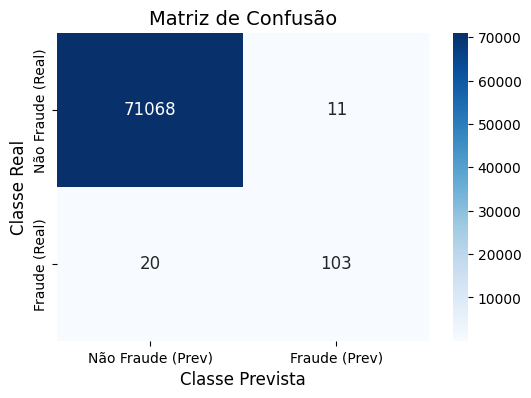


Detalhes da Matriz de Confusão:
Verdadeiros Negativos (Não-Fraudes OK): 71068
Falsos Positivos (Não-Fraudes -> Fraude): 11 <-- Erro Tipo I
Falsos Negativos (Fraudes -> Não Fraude): 20 <-- Erro Tipo II (CRÍTICO para fraude)
Verdadeiros Positivos (Fraudes OK): 103

Acurácia Geral: 0.9996


In [29]:
if model is not None and X_test is not None and y_test is not None:
    print("\nAvaliando o modelo no conjunto de teste...")
    try:
        proba_predictions = model.predict_proba(X_test)[:, 1]
        print(f"Utilizando limiar de classificação: {LIMIAR_CLASSIFICACAO}")
        predictions = (proba_predictions >= LIMIAR_CLASSIFICACAO).astype(int)

        print("\n--- Relatório de Classificação ---")
        print(classification_report(y_test, predictions, zero_division=0))

        print("\n--- Matriz de Confusão ---")
        cm = confusion_matrix(y_test, predictions)
        
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Não Fraude (Prev)', 'Fraude (Prev)'], 
                    yticklabels=['Não Fraude (Real)', 'Fraude (Real)'],
                    annot_kws={"size": 12})
        plt.title('Matriz de Confusão', fontsize=14)
        plt.ylabel('Classe Real', fontsize=12)
        plt.xlabel('Classe Prevista', fontsize=12)
        plt.show()
        
        tn, fp, fn, tp = 0,0,0,0 
        if cm.size == 4: 
            tn, fp, fn, tp = cm.ravel()
        elif cm.size == 1 and len(np.unique(y_test)) == 1 : 
             if y_test.iloc[0] == 0: tn = cm[0,0]
             else: tp = cm[0,0]
        
        print(f"\nDetalhes da Matriz de Confusão:")
        print(f"Verdadeiros Negativos (Não-Fraudes OK): {tn}")
        print(f"Falsos Positivos (Não-Fraudes -> Fraude): {fp} <-- Erro Tipo I")
        print(f"Falsos Negativos (Fraudes -> Não Fraude): {fn} <-- Erro Tipo II (CRÍTICO para fraude)")
        print(f"Verdadeiros Positivos (Fraudes OK): {tp}")

        accuracy = accuracy_score(y_test, predictions)
        print(f"\nAcurácia Geral: {accuracy:.4f}")

    except Exception as e:
        print(f"Erro durante a avaliação ou predição: {e}")
else:
    print("Modelo não treinado ou dados de teste não disponíveis. Pulando avaliação.")

### 4.6 Importância das Features (Random Forest)

In [36]:
if model is not None and isinstance(X_final, pd.DataFrame) and hasattr(model, 'feature_importances_'):
    print("\n--- Importância das Features (Top 15) ---")
    try:
        importances = model.feature_importances_
        feature_names = X_final.columns 
        
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        print("Primeiras 15 features mais importantes:")
        display(feature_importance_df.head(15))

        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), 
                    palette='viridis', hue='feature', legend=False) # UPDATED LINE
        plt.title('Importância das Features (Top 15)', fontsize=14)
        plt.xlabel('Importância', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout() 
        plt.show()
    except Exception as e:
        print(f"Erro ao calcular/plotar importância das features: {e}")
else:
    print("Modelo não treinado, X_final não é DataFrame ou o modelo não suporta 'feature_importances_'. Pulando.")

SyntaxError: unmatched ')' (2007010517.py, line 15)

## 5. Conclusão e Próximos Passos

Nesta seção, você resumiria os resultados obtidos na execução atual e discutiria:
- Quão bem o modelo performou com as configurações atuais.
- O impacto do SMOTE (se aplicado).
- O efeito da engenharia de features.
- O efeito do limiar de classificação.
- Possíveis próximos passos: testar outros algoritmos, busca de hiperparâmetros mais exaustiva (GridSearchCV), engenharia de features mais avançada, etc.